<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C4/C4.html"><img src="../data/C4_nav.png" width="100"  style="float:right;" alt="C4"></a>
<h1>Novelty-Based Segmentation</h1> 
</div>

<br/>

<p>
Following Section 4.4.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introdue in this notebook a basic procedure for novelty detection. This approach was first introduced and applied to the audio domain by Foote.

<ul>
<li><span style="color:black">
Jonathan Foote: <strong>Automatic audio segmentation using a measure of audio novelty.</strong> Proceedings of the IEEE International Conference on Multimedia and Expo (ICME), New York, NY, USA, 2000, pp. 452&ndash;455.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_Foote00_segmentationNovelty_ICME.txt"> Bibtex </a>
</span></li>
</ul>    
</p> 

## Introduction

Segment boundaries in music are often accompanied by a change in instrumentation, dynamics, harmony, tempo, or some other characteristics. It is the objective of novelty-based structure analysis to locate points in time where such musical changes occur, thus marking the transition between two subsequent structural parts. In this notebook, we discuss a classical boundary detection procedure that is based on structural properties of [self-similarity matrices](../C4/C4S2_SSM.html) (SSM). 

Recall that an SSM reveals **block-like structures** in the case that the underlying feature sequence stays somewhat constant over the duration of an entire section. Often such a homogeneous segment is followed by another homogeneous segment that stands in contrast to the previous one. For example, a section played by strings may be followed by a section played by brass. Or there may be two **contrasting sections** each being homogeneous with respect to harmony, where the boundary between these sections is characterized by a change in the musical key. Contrasting homogeneous sections are reflected by a local **checkerboard-like block structure** in the SSM. 

As an example, we consider the Ormandy recording of [Hungarian Dance No. 5 by Johannes Brahms](../C4/C4S1_MusicStructureGeneral.html), where one has homogeneous $A$-part segments in $\mathrm{G}$ minor and homogeneous $C$-part segments in $\mathrm{G}$ major. The SSM is obtained by using [chroma-based features](../C3/C3S1_SpecLogFreq-Chromagram.html) in combination with [features smoothing techniques](../C4/C4S2_SSM-FeatureSmoothing.html).

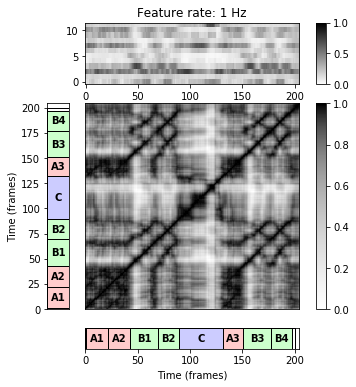

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit

sys.path.append('..')
import LibFMP.B
import LibFMP.C2
import LibFMP.C3
import LibFMP.C4

%matplotlib inline

# Annotation
filename = 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.csv'
fn_ann = os.path.join('..', 'data', 'C4', filename)
ann, color_ann = LibFMP.C4.read_structure_annotation(fn_ann, fn_ann_color=filename)

# SM
fn_wav = os.path.join('..', 'data', 'C4', 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.wav')
tempo_rel_set = LibFMP.C4.compute_tempo_rel_set(0.66, 1.5, 5)
x, x_duration, X, Fs_X, S, I = LibFMP.C4.compute_SM_from_filename(fn_wav, 
                                                L=81, H=10, L_smooth=1, thresh=1)

# Visualization
ann_frames = LibFMP.C4.convert_structure_annotation(ann, Fs=Fs_X) 
fig, ax = LibFMP.C4.plot_feature_SSM(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1], 
            title='Feature rate: %0.0f Hz'%(Fs_X))

<audio style="width: 320px;" src="../data/C4/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.mp3" type="audio/mpeg" controls="controls"></audio>

## Overall Procedure

The idea of Foote's procedure is to measure local changes by correlating a small checkerboard-like kernel along the main diagonal of an SSM. This results in a **novelty function** that reveals a peak at time positions where the kernel meets a transition between two contrasting blocks. The overall pipeline of the novelty-based segmentation algorithm can be summarized as follows:

* Convert the audio recording into a sequence of audio features. 
* Compute an SSM while enhancing block-like structures.
* Compute a novelty function by shifting a checkerboard kernel over the diagonal.
* Look for [peaks of the novelty function](../C6/C6S1_PeakPicking.html) (corresponding to changes in the audio recording).

We now implement this procedure using the Brahms as our running example.

## Checkerboard Kernel: Box

Let $X=(x_1,x_2,\ldots x_N)$ be a feature sequence and $\mathbf{S}$ a self-similarity matrix of size $N\times N$ derived from $X$. Let us first consider an audio recording that consists of two homogeneous but contrasting sections. When visualized, the resulting SSM looks like a $2\times 2$ checkerboard. 

<img src="../data/C4/FMP_C4_F23a-b.png" width="400px" align="middle" alt="FMP_C4_F23a-b">

The two dark blocks on the main diagonal correspond to the regions of high similarity within the two sections. In contrast, the light regions outside these blocks express that there is a low cross-similarity between the sections. Thus, to find the boundary between the two sections one needs to identify the crux of the checkerboard. This can be done by correlating $\mathbf{S}$ with a kernel that itself looks like a checkerboard. The simplest such kernel is the $(2\times 2)$-unit kernel defined by

\begin{equation}
   \mathbf{K} = \left[\begin{array}{rr} -1 & 1\\ 1 & -1 \end{array}\right]
        = \left[\begin{array}{rr} 0 & \,\,\,\,\,1\\ 1 & 0 \end{array}\right] -
          \left[\begin{array}{rr} 1 & \,\,\,\,\,0\\ 0 & 1 \end{array}\right].
\end{equation}

This kernel can be written as the difference between a "coherence" and an "anti-coherence" kernel. The first kernel measures the self-similarity on either side of the center point and will be high when each of the two regions is homogeneous. The second kernel measures the cross-similarity between the two regions and will be high when there is little difference across the center point. The difference between the two values estimates the **novelty** of the feature sequence at the center point. The novelty is high when the two regions are self-similar but different from each other.

In audio structure analysis, where one is typically interested in changes on a larger time scale, kernels of larger size are used. Adopting a centered view, where a physical time position is associated to the center of a window or kernel, we assume that the size of the kernel is odd given by $M=2L+1$ for some $L\in\mathbb{N}$. A **box-like checkerboard kernel** of size $M$ is an $(M\times M)$ matrix $\mathbf{K}_\mathrm{Box}$, which is indexed by $[-L:L]\times[-L:L]$.  The matrix is defined by 

\begin{equation}
   \mathbf{K}_\mathrm{Box} = \mathrm{sgn}(k)\cdot \mathrm{sgn}(\ell),
\end{equation}

where $k,\ell\in[-L:L]$ and "$\mathrm{sgn}$'' is the sign function (being $-1$ for negative numbers, $0$ for zero, and $1$ for positive numbers). For example, in the case $L=2$, one obtains

\begin{equation}
   \mathbf{K}_\mathrm{Box} = \left[\begin{array}{rrrrr} 
						-1 & -1 & \,\,\,\,\,0 & 1 & 1 \\ 
						-1 & -1 & 0 &1 & 1 \\
						 0 &  0  & 0 & 0 &0 \\
						 1 & 1  & 0 & -1 & -1 \\
						 1 & 1  & 0 & -1 & -1       
 \end{array}\right]
\end{equation}

Note that the zero row and the zero column in the middle have been introduced more for theoretical reasons to ensure the symmetry of the kernel matrix. In the following code cell, we implement and visualize the box-like checkerboard kernel 

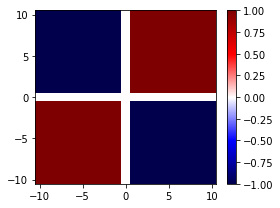

In [2]:
def compute_kernel_checkerboard_box(L):
    """Compute box-like checkerboard kernel [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L: Parameter specifying the kernel size M=2*L+1

    Returns:
        kernel: Kernel matrix of size M x M
    """       
    M = 2*L + 1
    axis = np.arange(-L,L+1)
    kernel = np.outer(np.sign(axis),np.sign(axis))
    return kernel

L = 10
kernel = compute_kernel_checkerboard_box(L)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower', 
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

## Checkerboard Kernel: Gaussian 

The checkerboard kernel can be smoothed to avoid edge effects using windows that taper towards zero at the edges. For this purpose, one may use a radially symmetric **Gaussian function** $\phi:\mathbb{R}^2\to \mathbb{R}$ defined by 

\begin{equation}
   \phi(s,t) = \mathrm{exp}(-\varepsilon^2(s^2+t^2)),
\end{equation}

where the parameter $\varepsilon>0$ allows for adjusting the degree of tapering. Then the **Gaussian checkerboard kernel** given by the matrix $\mathbf{K}_\mathrm{Gauss}$ is obtained by pointwise multiplication:

\begin{equation}
   \mathbf{K}_\mathrm{Gauss}(k,\ell) = \phi(k,\ell) \cdot \mathbf{K}_\mathrm{Box}(k,\ell),
\end{equation}

$k,\ell\in[-L:L]$. 

<img src="../data/C4/FMP_C4_F23c-d.png" width="400px" align="middle" alt="FMP_C4_F23c-d">

To compensate for the influence of the actual kernel size and of the tapering, one may normalize the kernel. This can be done by dividing the kernel by the sum over the absolute values of the kernel matrix:

\begin{equation}
   \mathbf{K}_\mathrm{norm}(k,\ell) = \frac{\mathbf{K}_\mathrm{Gauss}(k,\ell)}{\sum_{k,\ell\in[-L:L]}|\mathbf{K}_\mathrm{Gauss}(k,\ell)|}.
\end{equation}

The normalization becomes important when combining and fusing novelty information that is obtained from kernels of different size. In the following implementation, the taper parameter $\varepsilon$ is specified in terms of the variance $\sigma$ (normalized with respect to the kernel size $M=2L+1$).

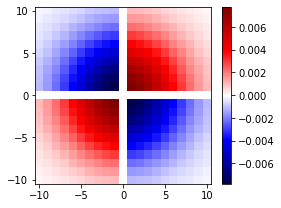

In [3]:
@jit(nopython=True)
def compute_kernel_checkerboard_Gaussian(L, var=1, normalize=True): 
    """Compute Guassian-like checkerboard kernel [FMP, Section 4.4.1]
    See also: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L: Parameter specifying the kernel size M=2*L+1
        var: Variance parameter determing the tapering (epsilon)

    Returns:
        kernel: Kernel matrix of size M x M
    """  
    taper = np.sqrt(1/2)/(L*var)
    axis = np.arange(-L,L+1)
    gaussian1D = np.exp(-taper**2 * (axis**2))
    gaussian2D = np.outer(gaussian1D,gaussian1D)
    kernel_box = np.outer(np.sign(axis),np.sign(axis))
    kernel = kernel_box * gaussian2D
    if normalize:     
        kernel = kernel / np.sum(np.abs(kernel))
    return kernel

L = 10
var = 0.5
kernel = compute_kernel_checkerboard_Gaussian(L, var)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower', 
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

## Novelty Function

To detect 2D corner points between adjoining blocks, the idea is to locally compare the SSM with a checkerboard kernel. To this end, we slide a suitable checkerboard kernel $\mathbf{K}$ along the main diagonal of the SSM and sum up the element-wise product of 
$\mathbf{K}$ and $\mathbf{S}$:

\begin{equation}
   \Delta_\mathrm{Kernel}(n) := \sum_{k,\ell\in[-L:L]} \mathbf{K}(k,\ell)\mathbf{S}(n+k,n+\ell)
\end{equation}

for $n\in[L+1:N-L]$. Extending the matrix $\mathbf{S}$ on the boundaries by **zero-padding** (i.e., by setting $\mathbf{S}(k,\ell)=0$ for $(k,\ell)\in\mathbb{Z}\times\mathbb{Z}\setminus[1:N]\times[1:N]$), one may assume $n\in[1:N]$. This defines a function $\Delta_\mathrm{Kernel}:[1:N]\to\mathbb{R}$, also referred to as the **novelty function**, which specifies for each index $n\in[1:N]$ of the feature sequence a measure of novelty $\Delta_\mathrm{Kernel}(n)$. When the kernel $\mathbf{K}$ is positioned within a relatively uniform region of $\mathbf{S}$, the positive and negative values of the product tend to sum to zero and $\Delta_\mathrm{Kernel}(n)$ becomes small. Conversely, when the kernel $\mathbf{K}$ is positioned exactly at the crux of a checkerboard-like structure of $\mathbf{S}$, the values of the product are all positive and sum up to a large value $\Delta_\mathrm{Kernel}(n)$. 

<img src="../data/C4/FMP_C4_F24_color.png" width="300px" align="middle" alt="FMP_C4_F24_color">

The following code cell provides an implementation for computing a novelty function. 

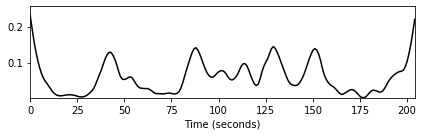

In [4]:
#@jit(nopython=True)
def compute_novelty_SSM(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        S: SSM
        kernel: Checkerboard kernel (if kernel==None, it will be computed)
        L: Parameter specifying the kernel size M=2*L+1
        var: Variance parameter determing the tapering (epsilon)
        exclude: Sets the first L and last L values of novelty function to zero

    Returns:
        nov: Novelty function
    """    
    if kernel is None:
        kernel = compute_kernel_checkerboard_Gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2*L + 1
    nov = np.zeros(N)
    #np.pad does not work with numba/jit
    S_padded  = np.pad(S,L,mode='constant')
    
    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n:n+M, n:n+M]  * kernel)
    if exclude:
        right = np.min([L,N])
        left = np.max([0,N-L])
        nov[0:right] = 0
        nov[left:N] = 0
        
    return nov

L_kernel = 20
nov = compute_novelty_SSM(S, L=L_kernel, exclude=False)   
fig, ax, line = LibFMP.B.plot_signal(nov, Fs = Fs_X, color='k')    

In the above example, the novelty curve was computed for the chroma-based SSM of our Brahms example. First of all, one can notice that the novelty function has large values at the beginning and at the end. This artifact, which is due to **zeropadding** of the SSM, can be suppressed by setting the novelty curve $\Delta_\mathrm{Kernel}$ to zero for the first and last $L$ frames. The following figure shows the resulting novelty curve overlaid with the segment annotation. As indicated by the figure, the local maxima of the novelty function nicely indicate changes of harmony, which particularly occur at boundaries between segments corresponding to different musical parts.

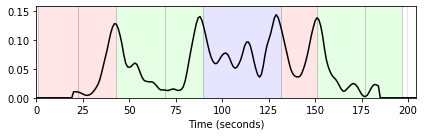

In [5]:
L_kernel = 20
nov = compute_novelty_SSM(S, L=L_kernel, exclude=True)        
fig, ax, line = LibFMP.B.plot_signal(nov, Fs = Fs_X, color='k') 
LibFMP.B.plot_segments_overlay(ann, ax=ax, colors=color_ann, alpha=0.1, edgecolor='k', print_labels=False)
plt.tight_layout()

## Kernel Size

Besides the quality of the SSM to start with, the size of the kernel has a significant impact on the properties of the novelty function. A **small kernel** may be suitable for detecting novelty on a short time scale, whereas a **large kernel** is suited for detecting boundaries and transitions between coarse structural sections. The suitability of a given kernel very much depends on the respective application and also on the properties of the underlying self-similarity matrix. The following example shows novelty functions using different sizes and SSMs based on different feature representations (with different features rates). Using a small kernel size may lead to a rather noisy novelty function with many spurious peaks. This particularly holds when the underlying SSM contains not only blocks but also path-like structures. Using a larger kernel averages out local fluctuations and results in a smoother novelty function. Note that a similar effect may be achieved by [smoothing the SSM](../C4/C4S2_SSM-FeatureSmoothing.html), which often leads to an enhancement of the block structure and an attenuation of the path structure. The interplay between SSM properties and kernel size is illustrated by the following figures.

<!--<img src="../data/C4/FMP_C4_F25_text.png" width="600px" align="middle" alt="FMP_C4_F25_text">-->


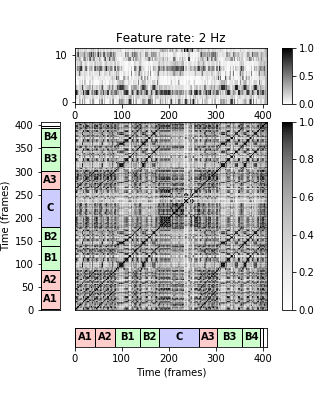
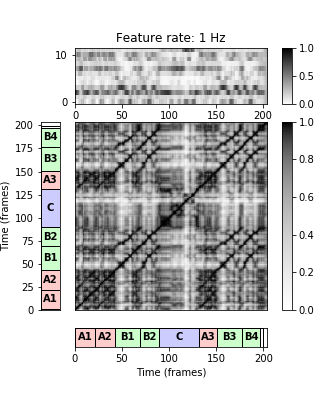

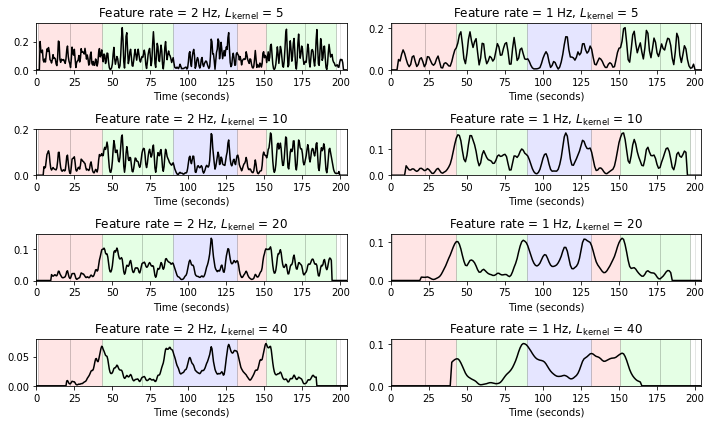

In [6]:
from LibFMP.B import FloatingBox
float_box = LibFMP.B.FloatingBox()

fn_wav = os.path.join('..', 'data', 'C4', 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.wav')


S_dict = {}
Fs_dict = {}
x, x_duration, X, Fs_X, S, I = LibFMP.C4.compute_SM_from_filename(fn_wav, 
                                                L=11, H=5, L_smooth=1, thresh=1)
S_dict[0], Fs_dict[0] = S, Fs_X
ann_frames = LibFMP.C4.convert_structure_annotation(ann, Fs=Fs_X) 
fig, ax = LibFMP.C4.plot_feature_SSM(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1], 
            title='Feature rate: %0.0f Hz'%(Fs_X), figsize=(4.5, 5.5))
float_box.add_fig(fig)

x, x_duration, X, Fs_X, S, I = LibFMP.C4.compute_SM_from_filename(fn_wav, 
                                                L=41, H=10, L_smooth=1, thresh=1)
S_dict[1], Fs_dict[1] = S, Fs_X
ann_frames = LibFMP.C4.convert_structure_annotation(ann, Fs=Fs_X) 
fig, ax = LibFMP.C4.plot_feature_SSM(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1], 
            title='Feature rate: %0.0f Hz'%(Fs_X), figsize=(4.5, 5.5))
float_box.add_fig(fig)
float_box.show()


figsize=(10,6)
L_kernel_set = [5, 10, 20, 40]
num_kernel = len(L_kernel_set)
num_SSM = len(S_dict)

fig, ax = plt.subplots(num_kernel, num_SSM, figsize=figsize)
for s in range(num_SSM):
    for t in range(num_kernel):
        L_kernel = L_kernel_set[t]
        S = S_dict[s]
        nov = compute_novelty_SSM(S, L=L_kernel, exclude=True)        
        fig_nov, ax_nov, line_nov = LibFMP.B.plot_signal(nov, Fs = Fs_dict[s], 
                color='k', ax=ax[t,s], figsize=figsize, 
                title='Feature rate = %0.0f Hz, $L_\mathrm{kernel}$ = %d'%(Fs_dict[s],L_kernel)) 
        LibFMP.B.plot_segments_overlay(ann, ax=ax_nov, colors=color_ann, alpha=0.1, 
                                       edgecolor='k', print_labels=False)
plt.tight_layout()
plt.show()  

## Further Notes

In the novelty detection procedure, there are many choices including the feature representation and the kernel size. Moreover, the [**peak selection strategy**](../C6/C6S1_PeakPicking.html) is also a delicate step that may have a substantial influence on the quality of the final result. Often, **adaptive thresholding** strategies where a peak is only selected when its value exceeds a local average of the novelty function are applied. To further reduce the number of spurious peaks, another strategy is to impose a constraint on the minimal distance between two subsequent peak positions. For further details, we refer to the [FMP notebook on peak picking](../C6/C6S1_PeakPicking.html).

<!--
* References for peak picking
* Notebook on peak picking
-->

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Julian Reck.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>